# Compare charged kWh measured by Mini with Walli

In [6]:
import os
from scipy import optimize
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
pd.options.display.max_rows = 100

In [21]:
dir_ = "C:\\Users\\holge\\Google Drive\\Mini-Ladehistorie"
os.listdir(dir_)

['MINI Ladehistorie April 2021.xlsx.xlsx',
 'MINI Ladehistorie August 2021.xlsx.xlsx',
 'MINI Ladehistorie Dezember 2021.xlsx.xlsx',
 'MINI Ladehistorie Februar 2022.xlsx.xlsx',
 'MINI Ladehistorie Januar 2022.xlsx.xlsx',
 'MINI Ladehistorie Juli 2021.xlsx.xlsx',
 'MINI Ladehistorie Juni 2021.xlsx.xlsx',
 'MINI Ladehistorie Mai 2021.xlsx.xlsx',
 'MINI Ladehistorie März 2021.xlsx.xlsx',
 'MINI Ladehistorie November 2021.xlsx.xlsx',
 'MINI Ladehistorie Oktober 2021.xlsx.xlsx',
 'MINI Ladehistorie September 2021.xlsx.xlsx',
 'walli_data_campaign_0.csv']

In [8]:
desired_cols = ['Angesteckt', 'Kilometerstand', 'Ladezustand beim Anstecken', 
       'Abgesteckt', 'Ladezustand beim Abstecken', 'Adresse',
       'Strommenge(*)', 'Ladedauer']

In [9]:
df = pd.DataFrame()
for fn in os.listdir(dir_):
    if fn.startswith("MINI Ladehistorie"):
        fp = os.path.join(dir_, fn)
        df = pd.concat([df, pd.read_excel(fp, header=5)])

# drop undesired cols and na rows
df = df[desired_cols]              
df = df[~df["Abgesteckt"].isna()]  

# Unify all Adresses containing "Ohlauer" to "zuhause"
df["Adresse"] = ["Zuhause" if "Ohlauer" in adr else adr for adr in df["Adresse"]]

# Convert str to datetime 
for dt_col in ["Angesteckt", "Abgesteckt"]:
    df[dt_col] = [dt.datetime.strptime(s, "%d.%m.%Y %H:%M") for s in df[dt_col]]
    
# Make Kilometerstand a Number
df["Kilometerstand"] = [int(km.replace("km", "").replace(".", "")) for km in df["Kilometerstand"]] 
df.head()

,Angesteckt,Kilometerstand,Ladezustand beim Anstecken,Abgesteckt,Ladezustand beim Abstecken,Adresse,Strommenge(*),Ladedauer
0,2021-04-27 17:20:00,491,0.386,2021-04-28 07:31:00,1.0,Zuhause,~ 23 kWh,10h 09min
1,2021-04-21 21:04:00,374,0.374,2021-04-22 11:22:00,1.0,Zuhause,~ 23 kWh,9h 55min
2,2021-04-19 19:00:00,260,0.366,2021-04-20 07:12:00,1.0,Zuhause,~ 23 kWh,10h 06min
3,2021-04-11 18:31:00,152,0.689,2021-04-12 07:45:00,1.0,Zuhause,~ 13 kWh,5h 33min
0,2021-08-19 17:15:00,3187,0.500,2021-08-19 20:27:00,1.0,Zuhause,~ 18 kWh,2h 51min


In [10]:
df.columns

Index(['Angesteckt', 'Kilometerstand', 'Ladezustand beim Anstecken',
       'Abgesteckt', 'Ladezustand beim Abstecken', 'Adresse', 'Strommenge(*)',
       'Ladedauer'],
      dtype='object')

In [11]:
df.columns = ['begin', 'km', 'SOC_begin', 'end', 'SOC_end', 'adr', 'kWh', 't_charge']
df = df.sort_values("begin")
df.head()

,begin,km,SOC_begin,end,SOC_end,adr,kWh,t_charge
0,2021-03-26 16:39:00,93,0.492,2021-03-27 10:06:00,1.0,Zuhause,~ 20 kWh,8h 48min
3,2021-04-11 18:31:00,152,0.689,2021-04-12 07:45:00,1.0,Zuhause,~ 13 kWh,5h 33min
2,2021-04-19 19:00:00,260,0.366,2021-04-20 07:12:00,1.0,Zuhause,~ 23 kWh,10h 06min
1,2021-04-21 21:04:00,374,0.374,2021-04-22 11:22:00,1.0,Zuhause,~ 23 kWh,9h 55min
0,2021-04-27 17:20:00,491,0.386,2021-04-28 07:31:00,1.0,Zuhause,~ 23 kWh,10h 09min


In [12]:
# convert kWh from str to int
#   '~ 6 kWh'  --> 6 
#   '< 2 kWh'  --> 1  because of '<'
kWh = []
for s in df.kWh:
    adder = 0
    if "<" in s:
        adder = -1
    for char in "~<kWh ":
        s = s.replace(char, "")
    kWh.append(int(s)+adder)
df.kWh = kWh
df.head()

,begin,km,SOC_begin,end,SOC_end,adr,kWh,t_charge
0,2021-03-26 16:39:00,93,0.492,2021-03-27 10:06:00,1.0,Zuhause,20,8h 48min
3,2021-04-11 18:31:00,152,0.689,2021-04-12 07:45:00,1.0,Zuhause,13,5h 33min
2,2021-04-19 19:00:00,260,0.366,2021-04-20 07:12:00,1.0,Zuhause,23,10h 06min
1,2021-04-21 21:04:00,374,0.374,2021-04-22 11:22:00,1.0,Zuhause,23,9h 55min
0,2021-04-27 17:20:00,491,0.386,2021-04-28 07:31:00,1.0,Zuhause,23,10h 09min


In [13]:
# convert t_charge from str to timedelta
#   '8h 48min'  case 1
#   '11 min'    case 2
td = []
for s in df.t_charge:
    if "h" in s:
        hours, mins = s.split("h")
    else:
        hours, mins = 0, s
    mins = int(mins.replace("min", "")) 
    mins += 60 * int(hours)
    td.append(dt.timedelta(seconds=60*mins))
df["t_charge"] = td
df.head()

,begin,km,SOC_begin,end,SOC_end,adr,kWh,t_charge
0,2021-03-26 16:39:00,93,0.492,2021-03-27 10:06:00,1.0,Zuhause,20,08:48:00
3,2021-04-11 18:31:00,152,0.689,2021-04-12 07:45:00,1.0,Zuhause,13,05:33:00
2,2021-04-19 19:00:00,260,0.366,2021-04-20 07:12:00,1.0,Zuhause,23,10:06:00
1,2021-04-21 21:04:00,374,0.374,2021-04-22 11:22:00,1.0,Zuhause,23,09:55:00
0,2021-04-27 17:20:00,491,0.386,2021-04-28 07:31:00,1.0,Zuhause,23,10:09:00


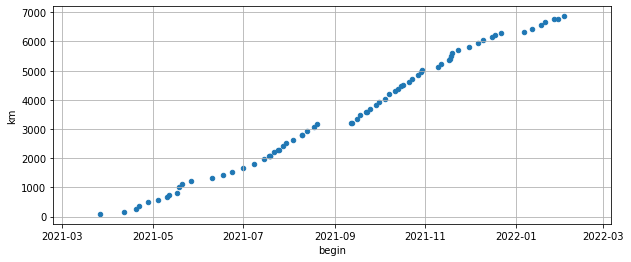

In [14]:
df.plot(kind="scatter", x="begin", y="km", grid="both", figsize=(10,4));

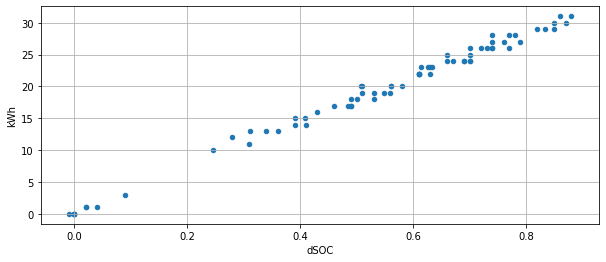

In [15]:
df["dSOC"] = df.SOC_end - df.SOC_begin
df.plot(kind="scatter", x="dSOC", y="kWh", grid="both", figsize=(10,4));

In [16]:
def lin_func(x, m, b):
    return m * x + b

params, _ = optimize.curve_fit(lin_func, df.dSOC, df.kWh)
m, b = params
lin_x = [0, 1]
lin_y = [lin_func(x, m, b) for x in lin_x]
lin_y

[0.5156717052164066, 35.443061589261134]

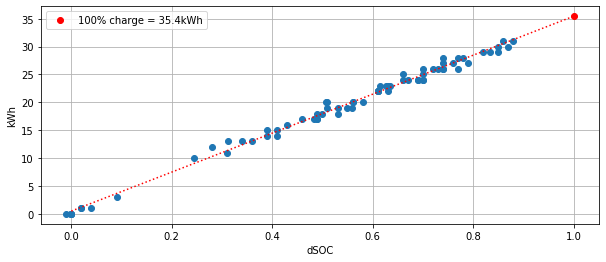

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(df.dSOC, df.kWh, "o")
plt.plot(lin_x, lin_y, "r:")
plt.plot(lin_x[1], lin_y[1], "ro", label=f"100% charge = {lin_y[1] :.1f}kWh")
plt.xlabel("dSOC"), plt.ylabel("kWh"), plt.legend(), plt.grid();

In [18]:
df["h_charge"] = [td/dt.timedelta(hours=1) for td in df.t_charge]
df.head()

,begin,km,SOC_begin,end,SOC_end,adr,kWh,t_charge,dSOC,h_charge
0,2021-03-26 16:39:00,93,0.492,2021-03-27 10:06:00,1.0,Zuhause,20,08:48:00,0.508,8.800000
3,2021-04-11 18:31:00,152,0.689,2021-04-12 07:45:00,1.0,Zuhause,13,05:33:00,0.311,5.550000
2,2021-04-19 19:00:00,260,0.366,2021-04-20 07:12:00,1.0,Zuhause,23,10:06:00,0.634,10.100000
1,2021-04-21 21:04:00,374,0.374,2021-04-22 11:22:00,1.0,Zuhause,23,09:55:00,0.626,9.916667
0,2021-04-27 17:20:00,491,0.386,2021-04-28 07:31:00,1.0,Zuhause,23,10:09:00,0.614,10.150000


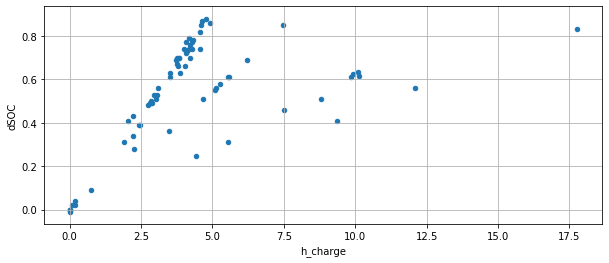

In [19]:
df.plot(kind="scatter", x="h_charge", y="dSOC", grid="both", figsize=(10,4));

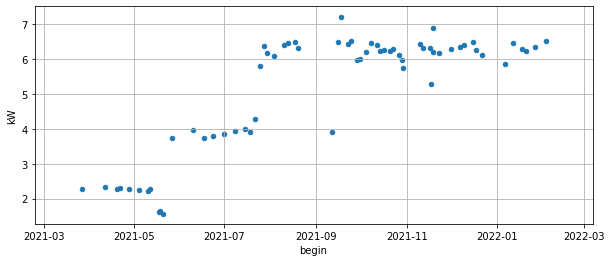

In [20]:
df["kW"] = df.kWh / df.h_charge
df.loc[df.h_charge < 0.2, "kW"] = np.nan  # don't use very short charge times
df.plot(kind="scatter", x="begin", y="kW", grid="both", figsize=(10,4));

# Read Walli Data

In [55]:
wd = pd.read_csv(os.path.join(dir_, 'walli_data_campaign_0.csv'), sep=";", decimal=",")
wd = wd[['datetime', 'charging_state', 'temperature', 'power_kW', 'energy_kWh']]
wd.datetime = pd.to_datetime(wd.datetime)
wd.tail()

,datetime,charging_state,temperature,power_kW,energy_kWh
3638,2022-02-12 14:00:00.012936,2,13.7,0.0,1019.485
3639,2022-02-12 15:00:00.027700,2,14.3,0.0,1019.485
3640,2022-02-12 16:00:00.018560,2,14.3,0.0,1019.485
3641,2022-02-12 17:00:00.033125,2,14.3,0.0,1019.485
3642,2022-02-12 18:00:00.022352,2,14.0,0.0,1019.485


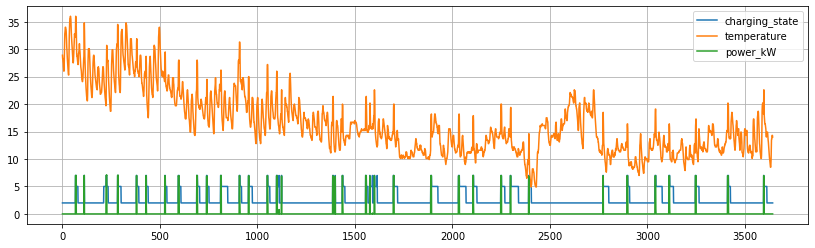

In [48]:
wd[['charging_state', 'temperature', 'power_kW']].plot(grid="both", figsize=(14,4));

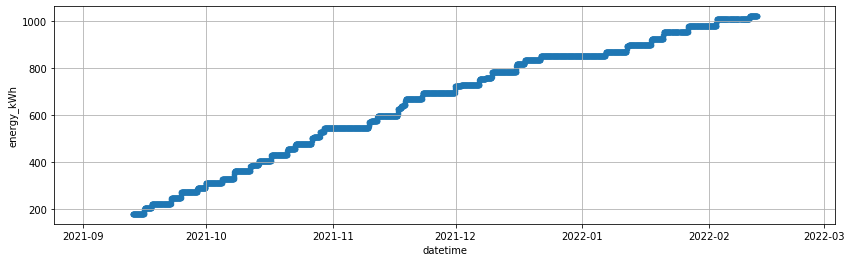

In [57]:
wd.plot(kind="scatter", x="datetime", y="energy_kWh", grid="both", figsize=(14,4));

In [64]:
wd["charged_kWh"] = wd.energy_kWh.diff()
wd.charged_kWh.sum(), wd.energy_kWh.max() - wd.energy_kWh.min() 

(838.806, 838.806)

In [98]:
wd.head()

,datetime,charging_state,temperature,power_kW,energy_kWh,charged_kWh
0,2021-09-13 00:00:00,2,28.9,0.0,180.679,NaN
1,2021-09-13 01:00:00,2,28.3,0.0,180.679,0.0
2,2021-09-13 02:00:00,2,28.3,0.0,180.679,0.0
3,2021-09-13 03:00:00,2,27.7,0.0,180.679,0.0
4,2021-09-13 04:00:00,2,27.5,0.0,180.679,0.0


In [99]:
wc = wd[["datetime", "charged_kWh"]].set_index("datetime").resample(dt.timedelta(days=1)).sum()
wc.index = [t.date() for t in wc.index]
wc.columns = ["Walli_kWh"]
wc.tail()

,Walli_kWh
2022-02-08,0.000
2022-02-09,0.000
2022-02-10,13.434
2022-02-11,0.000
2022-02-12,0.000


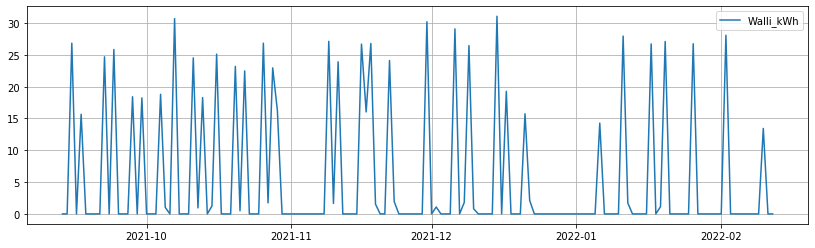

In [100]:
wc.plot(grid="both", figsize=(14,4));

# Compare Mini and Walli data

In [85]:
df.head()

,begin,km,SOC_begin,end,SOC_end,adr,kWh,t_charge,dSOC,h_charge,kW
0,2021-03-26 16:39:00,93,0.492,2021-03-27 10:06:00,1.0,Zuhause,20,08:48:00,0.508,8.800000,2.272727
3,2021-04-11 18:31:00,152,0.689,2021-04-12 07:45:00,1.0,Zuhause,13,05:33:00,0.311,5.550000,2.342342
2,2021-04-19 19:00:00,260,0.366,2021-04-20 07:12:00,1.0,Zuhause,23,10:06:00,0.634,10.100000,2.277228
1,2021-04-21 21:04:00,374,0.374,2021-04-22 11:22:00,1.0,Zuhause,23,09:55:00,0.626,9.916667,2.319328
0,2021-04-27 17:20:00,491,0.386,2021-04-28 07:31:00,1.0,Zuhause,23,10:09:00,0.614,10.150000,2.266010


In [118]:
df["date"] = [t.date() for t in df.begin]
mc = df[df.adr == "Zuhause"]
mc = mc[["date", "kWh"]].set_index("date")
mc.columns = ["Mini_kWh"]
mc.head()

,Mini_kWh
date,
2021-03-26,20
2021-04-11,13
2021-04-19,23
2021-04-21,23
2021-04-27,23


In [119]:
jc = mc.join(wc).dropna(axis=0)
jc.sum(axis=0)

Mini_kWh     792.000
Walli_kWh    807.354
dtype: float64

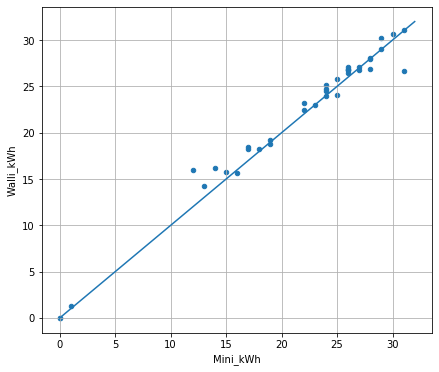

In [124]:
jc.plot(kind="scatter", x="Mini_kWh", y="Walli_kWh", grid="both", figsize=(7,6))
plt.plot([0, 32], [0, 32]);

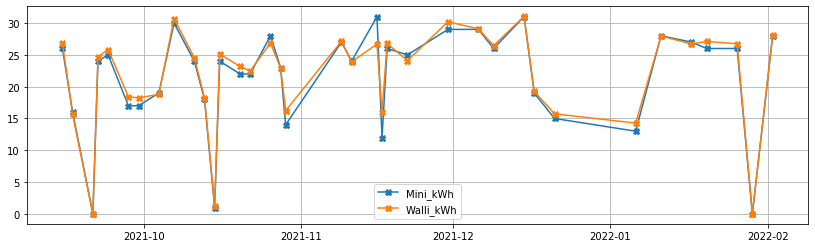

In [129]:
jc.plot(style="X-", grid="both", figsize=(14,4));

In [130]:
jc

,Mini_kWh,Walli_kWh
2021-09-15,26,26.832
2021-09-17,16,15.657
2021-09-21,0,0.000
2021-09-22,24,24.693
2021-09-24,25,25.839
2021-09-28,17,18.417
2021-09-30,17,18.232
2021-10-04,19,18.800
2021-10-07,30,30.700
2021-10-11,24,24.526


# Understand 16./17.11 difference

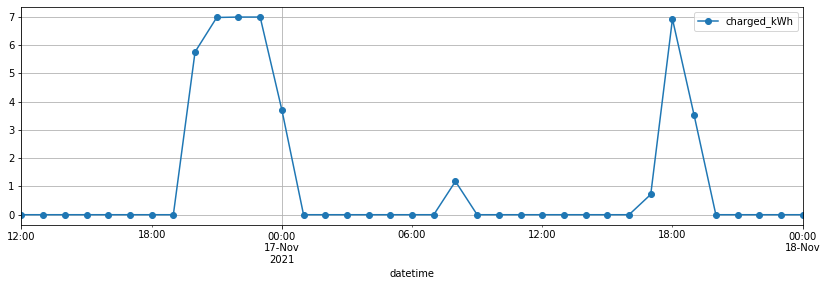

In [140]:
sd = wd[["datetime", "charged_kWh"]].set_index("datetime")
sd[dt.datetime(2021,11,16,12):dt.datetime(2021,11,18)].plot(style="o-", grid="both", figsize=(14,4));